In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.cm as cm
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [ ]:
train_path=r'/content/drive/MyDrive/Knee_Osteoarthritis_Dataset_Preprocessed/train'
test_path=r'/content/drive/MyDrive/Knee_Osteoarthritis_Dataset_Preprocessed/test'
valid_path=r'/content/drive/MyDrive/Knee_Osteoarthritis_Dataset_Preprocessed/validation'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images=  2286   Severe  has the least images=  173
average height=  224  average width=  223 aspect ratio=  1.0012515644555695


In [ ]:
drop_classes = ['Doubtful', 'Minimal']

train_df = train_df[~train_df['labels'].isin(drop_classes)]
valid_df = valid_df[~valid_df['labels'].isin(drop_classes)]
test_df = test_df[~test_df['labels'].isin(drop_classes)]

# Update the list of classes
list_of_classes = [c for c in list_of_classes if c not in drop_classes]

# Re-calculate the total classes
class_count = len(list_of_classes)

# Re-count the images per class
groups = train_df.groupby('labels')
for label in list_of_classes:
    group = groups.get_group(label)
    print(label, len(group))

Healthy 2286
Moderate 757
Severe 173


In [ ]:
img_size = (224,224)

In [ ]:
batch_size=32 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 3216 validated image filenames belonging to 3 classes.
Found 461 validated image filenames belonging to 3 classes.
Found 913 validated image filenames belonging to 3 classes.
test batch size:  11   test steps:  83  number of classes :  3


In [ ]:
# Load your model
model = load_model('/content/drive/MyDrive/Knee_Osteoarthritis_Model/InceptionV3_3Class.h5')  # Update with actual model path
model.summary()

In [ ]:
# Last layer
conv_output = model.get_layer("mixed10").output  # Update if necessary
grad_model = tf.keras.models.Model(
    [model.inputs], [conv_output, model.output]
)

# model
model.layers[-1].activation = None


In [ ]:
# Predictor function
def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    preds = model.predict(test_gen, verbose=True)
    correctly_predicted_indices = []

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = test_gen.labels[i]  # labels are integer values
        y_pred.append(p)  # Append the entire prediction array
        if pred_index == true_index:
            correctly_predicted_indices.append(i)

    acc = (len(correctly_predicted_indices) / len(preds)) * 100
    print(f'Accuracy: {acc:.2f}%')

    clr = classification_report(y_true, [np.argmax(p) for p in y_pred], target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)
    return correctly_predicted_indices, y_pred

# Grad-CAM functions
def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)
    return superimposed_img


In [ ]:
# Run predictor function
correctly_predicted_indices, y_pred = predictor(test_gen, test_steps)

# ***GRAD-CAM***

<ipython-input-12-c09b3b07a69d>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


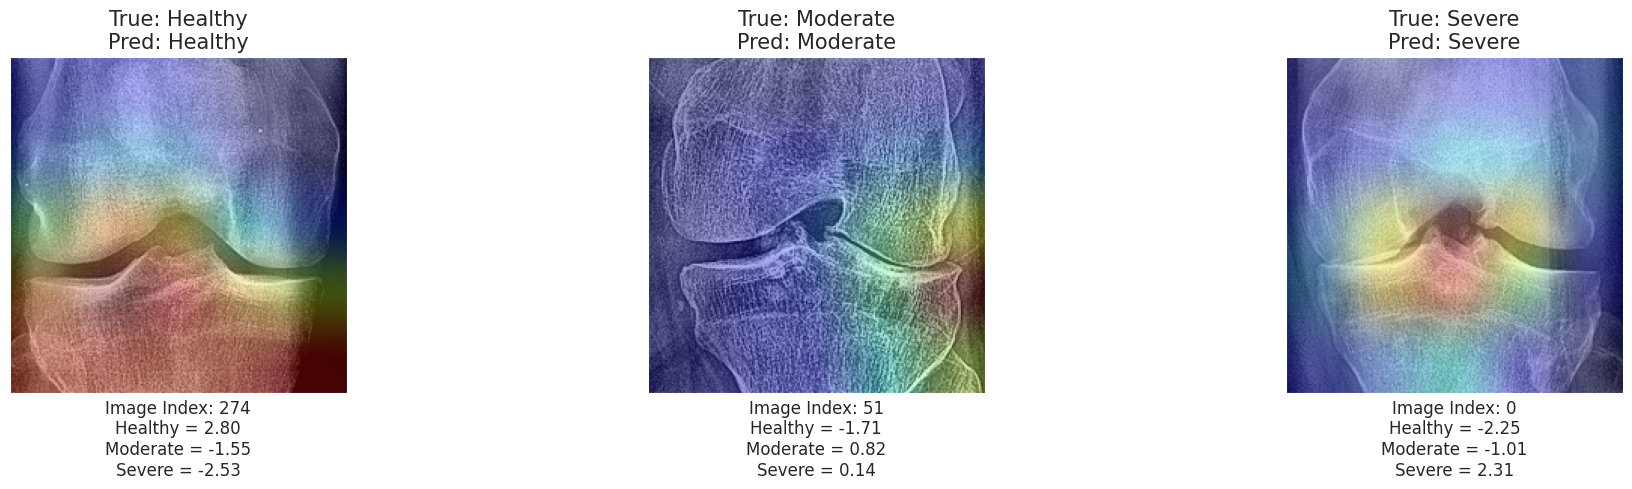

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm

# Define the number of classes and images per class
num_classes_to_display = 3
num_images_per_class = 1
selected_classes = list_of_classes[:num_classes_to_display]  # Modify this to select specific classes if needed

# Collect images for Grad-CAM output
collected_images = {class_name: [] for class_name in selected_classes}
class_display_count = {class_name: 0 for class_name in selected_classes}

# Collecting images for each class from correctly_predicted_indices
for index in correctly_predicted_indices:
    label = test_gen.labels[index]  # True label
    class_name = list_of_classes[label]

    # Check if the class is in the selected_classes and if we have already collected the required number of images for this class
    if class_name in selected_classes and class_display_count[class_name] < num_images_per_class:
        img_path = test_gen.filepaths[index]  # Get the file path of the image
        img = image.load_img(img_path, target_size=img_size)  # Resize to the expected shape
        img = image.img_to_array(img)
        img_aux = img.copy()
        img_array = np.expand_dims(img_aux, axis=0)
        img_array = np.float32(img_array)
        img_array = preprocess_input(img_array)

        pred_label = np.argmax(y_pred[index])

        heatmap = make_gradcam_heatmap(grad_model, img_array, pred_label)
        image_with_heatmap = save_and_display_gradcam(img, heatmap)

        collected_images[class_name].append((image_with_heatmap, class_name, list_of_classes[pred_label], y_pred[index], index))

        # Increment the display count for the class
        class_display_count[class_name] += 1

    # Break the loop if all selected classes have reached the display limit
    if all(count >= num_images_per_class for count in class_display_count.values()):
        break

# Ensure we have the required number of images for each class
for class_name in selected_classes:
    if len(collected_images[class_name]) < num_images_per_class:
        print(f"Warning: Not enough images for class {class_name}")
        collected_images[class_name] += [None] * (num_images_per_class - len(collected_images[class_name]))

# Plot collected images in a grid format (3 classes, 3 images each in one row)
fig, axes = plt.subplots(nrows=1, ncols=num_classes_to_display * num_images_per_class, figsize=(20, 5))

for i, class_name in enumerate(selected_classes):
    for j in range(num_images_per_class):
        img_index = i * num_images_per_class + j
        if collected_images[class_name][j] is not None:
            img, true_class, pred_class, pred_probs, img_idx = collected_images[class_name][j]
            ax = axes[img_index]
            ax.imshow(img)
            ax.set_title(f"True: {true_class}\nPred: {pred_class}", fontsize=15)
            ax.set_xlabel(f"Image Index: {img_idx}\n"
                          + "\n".join([f"{c} = {p:.2f}" for c, p in zip(list_of_classes, pred_probs)]),
                          fontsize=12)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax = axes[img_index]
            ax.axis('off')

plt.tight_layout()
plt.show()


# ***FasterScore-Cam***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm
import cv2

# Function to save and display Faster ScoreCAM
def save_and_display_faster_scorecam(img_path, heatmap, alpha=0.6):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    return superimposed_img

def faster_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradient of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Reshape conv_output to match the dimensions for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map efficiently
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


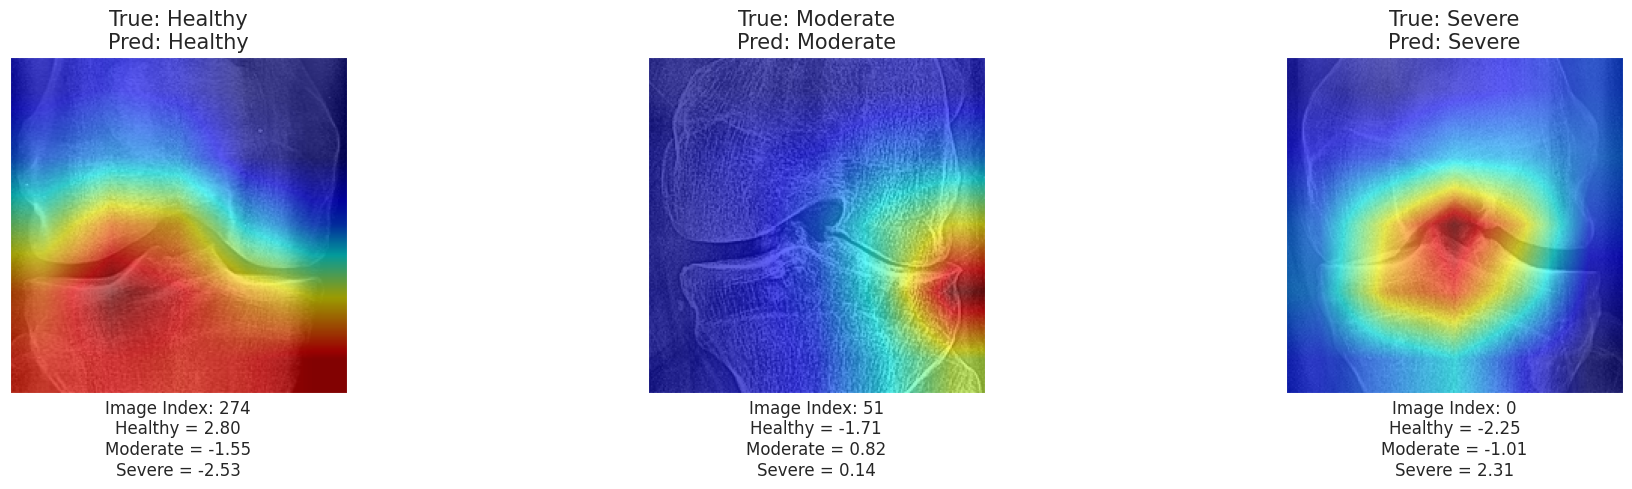

In [ ]:

# Collect images for Faster ScoreCAM output
num_classes_to_display = 3
num_images_per_class = 1
selected_classes = list_of_classes[:num_classes_to_display]  # Modify this to select specific classes if needed

collected_images = {class_name: [] for class_name in selected_classes}
class_display_count = {class_name: 0 for class_name in selected_classes}

# Collecting images for each class from correctly_predicted_indices
for index in correctly_predicted_indices:
    label = test_gen.labels[index]  # True label
    class_name = list_of_classes[label]

    # Check if the class is in the selected_classes and if we have already collected the required number of images for this class
    if class_name in selected_classes and class_display_count[class_name] < num_images_per_class:
        img_path = test_gen.filepaths[index]  # Get the file path of the image
        img = image.load_img(img_path, target_size=img_size)  # Resize to the expected shape
        img = image.img_to_array(img)
        img_aux = img.copy()
        img_array = np.expand_dims(img_aux, axis=0)
        img_array = np.float32(img_array)
        img_array = preprocess_input(img_array)

        pred_label = np.argmax(y_pred[index])

        heatmap = faster_scorecam_heatmap(img_array, model, "mixed10", pred_label)
        image_with_heatmap = save_and_display_faster_scorecam(img_path, heatmap)

        collected_images[class_name].append((image_with_heatmap, class_name, list_of_classes[pred_label], y_pred[index], index))

        # Increment the display count for the class
        class_display_count[class_name] += 1

    # Break the loop if all selected classes have reached the display limit
    if all(count >= num_images_per_class for count in class_display_count.values()):
        break

# Ensure we have the required number of images for each class
for class_name in selected_classes:
    if len(collected_images[class_name]) < num_images_per_class:
        print(f"Warning: Not enough images for class {class_name}")
        collected_images[class_name] += [None] * (num_images_per_class - len(collected_images[class_name]))

# Plot collected images in a grid format (3 classes, 3 images each in one row)
fig, axes = plt.subplots(nrows=1, ncols=num_classes_to_display * num_images_per_class, figsize=(20, 5))

for i, class_name in enumerate(selected_classes):
    for j in range(num_images_per_class):
        img_index = i * num_images_per_class + j
        if collected_images[class_name][j] is not None:
            img, true_class, pred_class, pred_probs, img_idx = collected_images[class_name][j]
            ax = axes[img_index]
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(f"True: {true_class}\nPred: {pred_class}", fontsize=15)
            ax.set_xlabel(f"Image Index: {img_idx}\n"
                          + "\n".join([f"{c} = {p:.2f}" for c, p in zip(list_of_classes, pred_probs)]),
                          fontsize=12)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax = axes[img_index]
            ax.axis('off')

plt.tight_layout()
plt.show()


# **LIME**

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=eec839ada6dd058d09189c16e29045c1664eef157d75b393e6843bad662da99d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


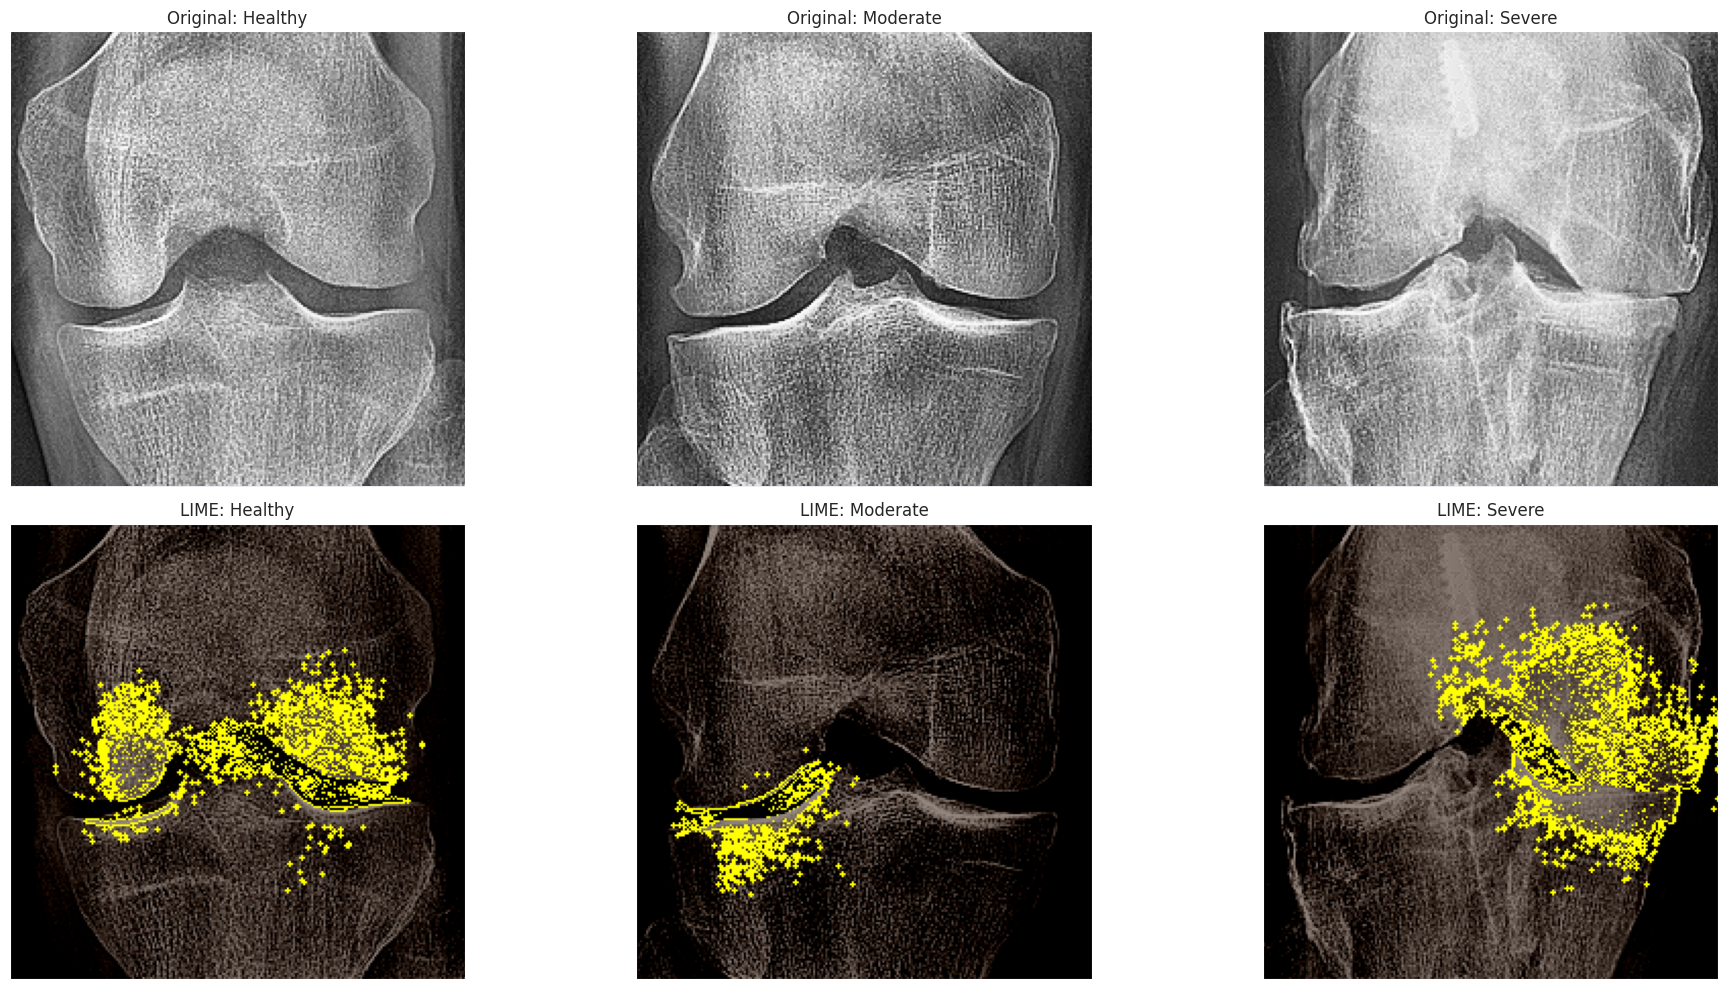

In [ ]:
# prompt: print the original images in ine row and the lime expalanations in the following row

import matplotlib.pyplot as plt
# Collect LIME explanations and original images
num_classes_to_display = 3
num_images_per_class = 1
selected_classes = list_of_classes[:num_classes_to_display]

collected_images = {class_name: [] for class_name in selected_classes}

# Redefine the explain_with_lime function without ax1 and ax2
def explain_with_lime(model, img_path, label):
    explainer = lime.lime_image.LimeImageExplainer()

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    explanation = explainer.explain_instance(img_array[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    img_boundry = mark_boundaries(temp / 255.0, mask)
    return img_boundry

for label in selected_classes:
    class_df = test_df[test_df['labels'] == label]
    sample_images = class_df.sample(n=num_images_per_class, random_state=123, axis=0)['filepaths'].tolist()
    for img_path in sample_images:
        lime_explanation = explain_with_lime(model, img_path, label) # Use the redefined function

        # Load and preprocess the original image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)

        collected_images[label].append((img_array, lime_explanation, label, img_path))  # Store original image, explanation, label, and image path

# Plot original images and LIME explanations in two rows
fig, axes = plt.subplots(nrows=2, ncols=num_classes_to_display * num_images_per_class, figsize=(20, 10))

for i, class_name in enumerate(selected_classes):
    for j in range(num_images_per_class):
        img_index = i * num_images_per_class + j
        if collected_images[class_name]:
            original_img, lime_explanation, true_label, img_path = collected_images[class_name][j]

            # Plot original image
            ax = axes[0, img_index]
            ax.imshow(original_img / 255.0)  # Scale pixel values to [0, 1] for display
            ax.set_title(f"Original: {true_label}", fontsize=12)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plot LIME explanation
            ax = axes[1, img_index]
            ax.imshow(lime_explanation)
            ax.set_title(f"LIME: {true_label}", fontsize=12)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            axes[0, img_index].axis('off')
            axes[1, img_index].axis('off')

plt.tight_layout()
plt.show()